# Языковые модели, 2026

## Векторизуем тексты

### Word2Vec

С точки зрения терминологии, word2vec не является языковой моделью, так как ничего не знает о сочетаемости слов. Однако для векторизации текста мы вполне можем его использовать.

In [1]:
!pip install pymorphy3 russian-tagsets gensim --q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 71.5 MB/s eta 0:00:00


In [2]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [3]:
import gensim.downloader
from pymorphy3 import MorphAnalyzer
from nltk.tokenize import word_tokenize
from russian_tagsets import converters
import numpy as np

morph = MorphAnalyzer()

# не совсем тот тагсет, но ruscorpora у них сломан
conv = converters.converter('opencorpora-int', 'ud20')

Наш текст:

In [4]:
text = '''Сплюшка — ночная птица. Среда обитания: Европа, юг Сибири до Байкала, Малая Азия до предгорий Средней Азии, Ближний Восток и Северная Африка. Перелётный вид. Зимует в тропической Африке, к югу от пустыни Сахары. Предпочитает лиственные леса, сады, парки, сосновые и арчовые редколесья, в Средиземноморье — оливковые рощи, часто селится возле человека, на плантациях, в горы поднимается до 3000 м над уровнем моря.

Обыкновенная сплюшка зимует в саваннах. В России появляется в апреле, улетает в августе-сентябре. Размножается в мае-июле (в некоторых районах с марта по август), гнездится обыкновенно в дуплах, расщелинах скал, реже — в гнёздах сорок и мелких хищных птиц, норах щурок, зимородков. В кладке обычно от 2 до 6 блестящих белых яиц массой по 15 г. Инкубационный период длится 25 дней, выкармливание — примерно 4 недели, вылетают из гнезда птенцы неделей позже. Окрас птенцов сероватый, с поперечными полосками, нехарактерными для взрослых птиц.

Питается сплюшка ночными бабочками и жуками, на позвоночных нападает редко. Может охотиться на мелких лягушек, ящериц, млекопитающих. В природе живёт до 6 лет.'''

Загрузим модель для русского языка:

In [5]:
w2v = gensim.downloader.load('word2vec-ruscorpora-300')

[==================================================] 100.0% 198.8/198.8MB downloaded


Функция для предобработки текста. К сожалению, word2vec не умеет работать с сырыми текстами:

In [6]:
def preprocess_text(text: str):
    res = []
    for word in word_tokenize(text):
        if word.isalpha():
            p = morph.parse(word)[0]
            word = p.normal_form


            pos = conv(str(p.tag.POS)).split(' ')[0]
            res.append(f'{word}_{pos}')
    return res

Функция для векторизации. Если вдруг все слова незнакомые, то возвращаем вектор из нулей:

In [7]:
def vectorize_text(text: list):
    res = []

    for word in text:
        if word in w2v:
            res.append(w2v[word])

    if len(res) == 0:
        return np.zeros(300)
    else:
        return np.vstack(res).mean(axis=0)

Смотрим, как работает:

In [8]:
norm_text = preprocess_text(text)
vectorize_text(norm_text).shape

(300,)

In [9]:
# vectorize_text(norm_text)

### BERT

У word2vec с точки зрения понимания текста есть несколько существенных недостатков:

- Не учитывает контекст (лук репчатый и лук как оружие $-$ это один и тот же вектор)
- Не учитывает порядок слов
- Плохо отличает синонимы от антонимов
- Не умеет работать с незнакомыми словами

Берт все эти проблемы решает :)

Понимание контекста в нем реализовано за счет __механизма внимания__ $-$ подхода, при котором мы учим модель получать специальную матрицу, обозначающую важность слов друг для друга.

Воспользоваться Бертом очень просто и для этого необязательно погружаться в нюансы его работы. Сначала загрузим модель и токенайзер (для нейросетевых моделей важно брать именно тот токенайзер, который привязан к модели):

In [10]:
from transformers import AutoTokenizer, AutoModel
import torch

In [11]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [12]:
model_name = "DeepPavlov/rubert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: DeepPavlov/rubert-base-cased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
bert.embeddings.position_ids               | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.decoder.weight             | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.decoder.bias               | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Теперь токенизируем наш текст

In [13]:
toks = tokenizer(text, padding='max_length', truncation=True,
                 return_tensors='pt', max_length=256)
toks

{'input_ids': tensor([[   101,   6386,   3049,  21593,    901, 102624,  30476,    132,   7045,
            626,  30199,    156,  28620,    128,  18919,  20234,   2785,  83041,
            128,  27598,  38111,   2785,  41546,   1572,  28249,  14412,    128,
          69008,  23529,    851,  18723,  42298,    132,  91045,   3650,   1916,
           3810,    132,  20000,   4742,    845,  76405,  22621,    128,    861,
          16941,   1641,  38075,  69023,    132,  91482, 118384,  18522,    128,
          44436,    128,  61783,    128,  99368,    851,   3132,  27682,   9209,
            842, 106583,   4122,    128,    845,  64197,    901,  39324,  20589,
          76589,    128,   9734,  73557,  23204,  16851,   6798,    128,   1469,
          93430,    128,    845,  17152,  40008,   2785,  15847,    865,   4700,
          14752,  10712,    132,  71098,   7898,  52440,  82599,  47406,   1465,
            845, 115313,  17881,    132,    781,   3590,  17499,    845,  11985,
            12

Кажется, мы получили больше токенов, чем ожидали. И здесь кроется важная особенность токенайзеров для нейросетевых моделей: "токен" — это не одно слово, а *некоторый частотный набор символов*. Иногда это по счастливому совпадению оказывается целым словом, но чаще — нет.

In [14]:
tokenizer.decode(toks['input_ids'][0])

'[CLS] Сплюшка — ночная птица. Среда обитания : Европа, юг Сибири до Байкала, Малая Азия до предгорий Средней Азии, Ближний Восток и Северная Африка. Перелётный вид. Зимует в тропической Африке, к югу от пустыни Сахары. Предпочитает лиственные леса, сады, парки, сосновые и арчовые редколесья, в Средиземноморье — оливковые рощи, часто селится возле человека, на плантациях, в горы поднимается до 3000 м над уровнем моря. Обыкновенная сплюшка зимует в саваннах. В России появляется в апреле, улетает в августе - сентябре. Размножается в мае - июле ( в некоторых районах с марта по август ), гнездится обыкновенно в дуплах, расщелинах скал, реже — в гнёздах сорок и мелких хищных птиц, норах щурок, зимородков. В кладке обычно от 2 до 6 блестящих белых яиц массой по 15 г. Инкубационный период длится 25 дней, выкармливание — примерно 4 недели, вылетают из гнезда птенцы неделей позже. Окрас птенцов сероватый, с поперечными полосками, нехарактерными для взрослых птиц. Питается сплюшка ночными бабочк

А еще токенайзер добавляет служебные токены [CLS] и [PAD]

Векторизуем наши токены:

In [15]:
with torch.no_grad():
    model_output = model(**{k: v.to(model.device) for k, v in toks.items()})

Посмотрим на результат. Мы можем использовать его двумя способами:
- Взять `last_hidden_state` и усреднить. Этот способ универсальный почти для всех моделей
- Взять `pooler_output`, где содежится векторное представление сразу для текста. Однако, если модель не готовили специально его считать, то оно может быть плохого качества (плохо отражать смысл текста)  

In [16]:
model_output

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.2241, -0.0019,  0.0785,  ...,  0.2264,  0.0758, -0.0442],
         [ 0.4427,  0.0658,  1.5546,  ...,  0.4873,  0.1003, -0.5505],
         [-0.1177, -0.0323,  0.6784,  ..., -1.1597,  0.0397, -0.8991],
         ...,
         [ 0.3158, -0.2801,  1.0091,  ...,  0.5333,  0.0901,  0.2476],
         [ 0.7528, -0.2329,  0.6841,  ..., -0.0848, -0.1435,  0.0168],
         [ 0.6321, -0.2623,  0.6973,  ...,  0.0528, -0.3355, -0.0391]]],
       device='cuda:0'), pooler_output=tensor([[ 8.1338e-02, -9.5885e-02,  2.2226e-02,  9.4442e-02, -1.1907e-01,
          1.0725e-01,  2.8398e-02,  2.9054e-01, -2.1994e-02,  7.9615e-02,
         -8.3494e-02, -6.0144e-02, -1.3087e-01, -1.4887e-01,  8.8144e-02,
         -2.2516e-01,  5.4762e-01,  4.5054e-03,  1.0326e-01, -1.4193e-01,
         -9.9992e-01, -5.6326e-02, -1.5355e-01, -1.1184e-01, -1.7928e-01,
          7.0176e-02, -1.0411e-01,  2.0802e-01,  2.2721e-01, -1.9219e-02,
          1.

И вот наш вектор текста

In [17]:
model_output.last_hidden_state.mean(dim=1).shape

torch.Size([1, 768])

## Визуализируем

Методы снижения размерности мы с вами уже обсуждали, но не применяли на настоящих данных. Давайте посмотрим, что получится при снижении размерности текстов

In [18]:
!pip install umap-learn -q

In [19]:
import pandas as pd
import umap
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure

Скачаем многоязычного Берта, чтобы он точно с чем угодно справился

In [20]:
model_name = "google-bert/bert-base-multilingual-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: google-bert/bert-base-multilingual-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Скачаем знакомый нам датасет новостей

In [21]:
my_groups = fetch_20newsgroups(
    categories=[
        'soc.religion.christian',
        'talk.politics.guns',
        'sci.med',
        'rec.autos',
        'comp.sys.mac.hardware'
    ])

df = pd.DataFrame({'text': my_groups['data'], 'target': my_groups['target']})
df.target = df.target.apply(lambda x: my_groups['target_names'][x])

df.head()

,text,target
0,From: black@sybase.com (Chris Black)\nSubject:...,sci.med
1,From: db7n+@andrew.cmu.edu (D. Andrew Byler)\n...,soc.religion.christian
2,From: mrl@pfc.mit.edu (Mark London)\nSubject: ...,sci.med
3,From: hades@coos.dartmouth.edu (Brian V. Hughe...,comp.sys.mac.hardware
4,From: tcorkum@bnr.ca (Trevor Corkum)\nSubject:...,rec.autos


Датасет большой, возьмем только 200 текстов из каждого класса

In [22]:
df = df.groupby('target').sample(200, random_state=42).reset_index(drop=True)
df.shape

(1000, 2)

Функция для векторизации текста батчами (пачками)

In [23]:
def vectorize_text(data, batch_size=256):
    res = []
    for i in tqdm(range(0, data.shape[0], batch_size)):
        text = data.iloc[i:i + batch_size].text.tolist()

        toks = tokenizer(text, padding='max_length', truncation=True,
                 return_tensors='pt', max_length=512)

        with torch.no_grad():
            model_output = model(**{k: v.to(model.device) for k, v in toks.items()})
        res.append(model_output.last_hidden_state.mean(dim=1).detach().cpu())

    res = torch.vstack(res)

    assert res.shape[0] == data.shape[0]
    return res

In [24]:
vecs = vectorize_text(df)

  0%|          | 0/4 [00:00<?, ?it/s]

Приведем наши данные к размерности два, чтобы можно было хорошо нарисовать

In [25]:
reducer = umap.UMAP(n_components=2)

vecs2 = reducer.fit_transform(vecs)
print(vecs2.shape)

(1000, 2)


Посмотрим, как соотносится наше отображение с классами из датасета. Кажется, что классы не совсем линейно разделимы

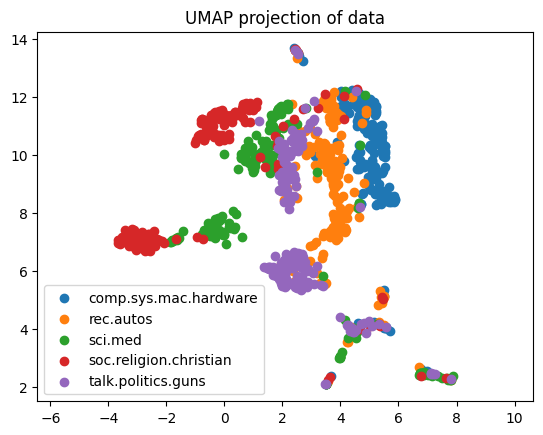

In [26]:
for topic in df.target.unique():
    idx = df[df.target == topic].index.tolist()

    plt.scatter(
        vecs2[idx, 0],
        vecs2[idx, 1],
        label=topic)

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of data', fontsize=12)
plt.legend()

Попробуем кластеризовать с помощью K-Means, чтобы понять, насколько такому алгоритму сложно работать со структурой, отобразившейся выше

In [27]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
kmeans.fit(vecs)

clust = kmeans.labels_
homogeneity_completeness_v_measure(df.target, clust)

(np.float64(0.28285993472531),
 np.float64(0.21759900791365963),
 np.float64(0.24597438842911074))

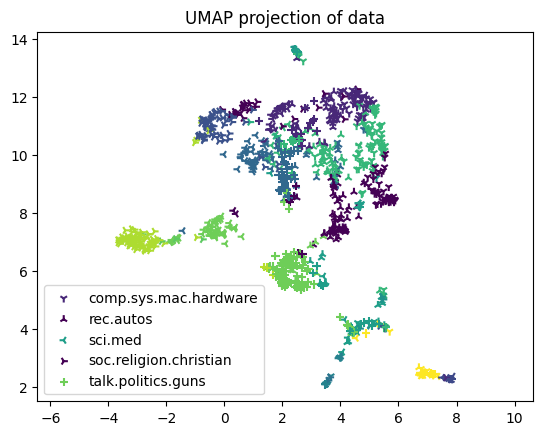

In [28]:
form = ['1', '2', '3', '4', '+']

topics = df.target.unique()
# topics = ['comp.sys.mac.hardware', 'rec.autos', 'sci.med', 'soc.religion.christian', 'talk.politics.guns']

for i, topic in enumerate(topics):
    idx = df[df.target == topic].index.tolist()

    plt.scatter(
        vecs2[idx, 0],
        vecs2[idx, 1],
        label=topic,
        c=clust[idx],
        marker=form[i]
        )

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of data', fontsize=12)
plt.legend()

А теперь попробуем кластеризацию на данных со сниженной размерностью. Заметим, что теперь границы между кластерами стали более ровные

In [29]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
kmeans.fit(vecs2)

clust = kmeans.labels_
homogeneity_completeness_v_measure(df.target, clust)

(np.float64(0.4701033099923183),
 np.float64(0.34038809748149923),
 np.float64(0.3948655589250278))

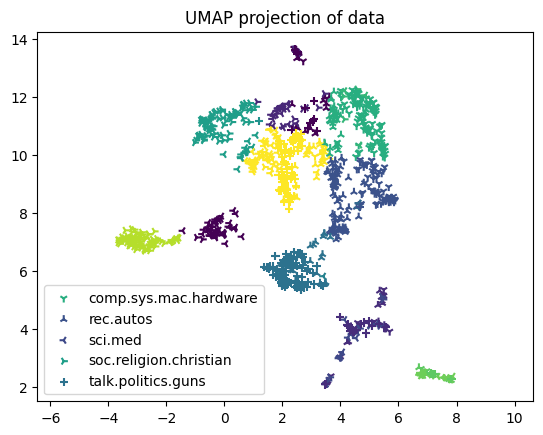

In [30]:
form = ['1', '2', '3', '4', '+']

topics = df.target.unique()
# topics = ['comp.sys.mac.hardware', 'rec.autos', 'sci.med', 'soc.religion.christian', 'talk.politics.guns']

for i, topic in enumerate(topics):
    idx = df[df.target == topic].index.tolist()

    plt.scatter(
        vecs2[idx, 0],
        vecs2[idx, 1],
        label=topic,
        c=clust[idx],
        marker=form[i]
        )

plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of data', fontsize=12)
plt.legend()

## Большие языковые модели

Внутри модели word2vec каждому слову ставится в соответвие вектор из 300 чисел. В Берте - обычно 512, 768 или 1024. Хотя на первый вгляд LLM могут выдавать вектора той же размерности, количество внутренних параметров, которое использовалось для получение итоговых репрезентаций, отличается в сотни, тысячи или даже десятки тысяч раз.

В стандартном Берте для русского языка порядка 180М параметров, и рядом с современными LLM он выглядит маленьким.

Как вы считаете, сколько же может быть у них параметров? И сколько же данных и времени надо, чтобы обучить что-то настолько огромное?

При этом сейчас большие языковые модели очень активно используются в качестве чат-ассистентов, способных оказывать помощь во множестве задач: от написания эссе или составления плана тренировок до создания сайта или даже обучения своей модели.

Но здесь важно понимать, что "Искусственный интеллект" не обладает интеллектом. Это просто генератор последовательности слов. **Лингвомодели не обладают никаким знанием о мире**, а только о последовательностях слов в текстах. Они не умеют рассуждать $-$ они умеют порождать тексты, похожие на рассуждения.

И при этом **модели часто генерируют галлюцинации**.

Галлюцинациями называют ответы больших языковых моделей, которые звучат правдиво, но на самом деле являются ошибочными. Простой пример $-$ вы спрашиваете у чат-бота, кто написал «Женитьбу Бальзаминова», а он отвечает $-$ Антон Чехов (на самом деле Александр Островский).

Основные причины галлюцинаций $-$ недостаток знаний и принцип работы языковой модели. При обучении она учится предсказывать вероятное продолжение на основе предыдущих слов. Если модель не выучила какой-то факт, например того же автора «Женитьбы», то предскажет другое имя или другого писателя, ведь это более вероятное продолжение, чем, например, «эту книгу написала собака».

*(Источник: [вк группа Яндекса](https://vk.com/wall-11283947_171639))*

**Моделям нельзя слепо доверять** $-$ впрочем, как и случайной ссылке из гугла. Но давайте поучимся, как мы можем их эффективно применять.

Вы можете использовать любого чат-бота, к которому у вас есть доступ (ChatGPT, Gemini, Bard, DeepSeek)

А вот здесь можно посмотреть всякие устоявшиеся приемы промптинга $-$ составления запросов к LLM так, чтобы она как можно лучше решала задачи: https://www.promptingguide.ai/ru (если переключить на английский, то информации будет больше)

Интересные статьи:

**Chain-of-Thought Prompting Elicits Reasoning in Large Language Models** https://arxiv.org/abs/2201.11903 — оригинальная статья про chain of thought

**Large Language Models Understand and Can be Enhanced by Emotional Stimuli** https://arxiv.org/abs/2307.11760 — "за каждый правильный ответ ты будешь получать $200"

**Principled Instructions Are All You Need for Questioning** https://arxiv.org/abs/2312.16171v1
> This paper introduces 26 guiding principles designed to streamline the process of querying and prompting large language models.

**Mind Your Format: Towards Consistent Evaluation of In-Context Learning Improvements** https://arxiv.org/abs/2401.06766 — про то, что важен даже формат подачи примеров

**Do Large Language Models Know What They Don't Know?** https://arxiv.org/abs/2305.18153 — о галлюцинациях